NNHIỆM VỤ BỔ SUNG: Thu thập dữ liệu đánh giá về manulife trên google maps: https://www.google.com/maps/place/B%E1%BA%A3o+Hi%E1%BB%83m+Manulife/@10.7814739,106.6906709,15.49z/data=!4m10!1m2!2m1!1smanulife!3m6!1s0x317528d318cfb18b:0xba954bd27cb9e831!8m2!3d10.7811083!4d106.6970667!15sCghtYW51bGlmZSIDiAEBWgoiCG1hbnVsaWZlkgERaW5zdXJhbmNlX2NvbXBhbnngAQA!16s%2Fg%2F11c38t5mw5?hl=vi&entry=ttu&g_ep=EgoyMDI0MDkyNS4wIKXMDSoASAFQAw%3D%3D

Xây dựng mô hình phân tích quan điểm đánh giá của người dùng về manulife.


In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
!pip install -q py_vncorenlp stop_words underthesea

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from stop_words import get_stop_words
stop_words_vi = get_stop_words('vi')
import py_vncorenlp
from tqdm import tqdm
import networkx as nx
from collections import Counter

import pandas as pd
from nltk import ngrams
from gensim.models import Word2Vec
from wordcloud import WordCloud

import sys
import importlib
import collections
import itertools
import matplotlib.pyplot as plt
import logging

In [ ]:
data = pd.read_csv('/content/datareview.csv')
if 'Content' in data.columns:
    # Thay thế các giá trị NaN trong cột 'Review Text' bằng chuỗi rỗng
    data['Content'] = data['Content'].fillna("")

In [ ]:
data

,Reviewer,Content,Date,Stars,Local Guide,Likes
0,Tung Anh Yogi,Mọi người thân thiện khi Ci Yoga Therapy đến l...,4 tuần trước,5 sao,2 bài đánh giá · 2 ảnh,0
1,Cẩm Thuy,"Hợp đồng không được chăm sóc, không có nhân vi...",3 tuần trước,1 sao,2 bài đánh giá · 3 ảnh,0
2,Hiền Trần,"Bạn bè, người thân nói mình mua bảo hiểm không...",2 tháng trước,1 sao,Local Guide · 25 bài đánh giá · 28 ảnh,0
3,Tuấn Anh Nguyễn,Manulife ủy quyền cho công ty này giải quyết c...,4 tháng trước,1 sao,16 bài đánh giá · 17 ảnh,2
4,Quyen Dinh,Tôi cần nhân viên giải quyết về quyền lợi của ...,3 tháng trước,1 sao,1 bài đánh giá · 8 ảnh,2
...,...,...,...,...,...,...
157,Mantra Layla,,6 năm trước,5 sao,2 bài đánh giá · 2 ảnh,0
158,Khanh Trần như,,6 năm trước,5 sao,Local Guide · 21 bài đánh giá · 23 ảnh,0
159,Thang Chu,,6 năm trước,5 sao,Local Guide · 50 bài đánh giá · 72 ảnh,0
160,tai le,,6 năm trước,2 sao,NaN,0


In [ ]:
import re
import string
from underthesea import word_tokenize
import pandas as pd

vietnamese_stopwords_file = '/content/vietnamese-stopwords.txt'

# Đọc các từ dừng tiếng Việt từ file
with open(vietnamese_stopwords_file, 'r', encoding='utf-8') as f:
    vietnamese_stopwords = f.read().splitlines()

def preprocess_text(text):

    # Chuyển văn bản thành chữ thường
    text = text.lower()

    # Loại bỏ URL
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r" ", text)

    # Loại bỏ thẻ HTML
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # Loại bỏ dấu câu và số
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    text = " ".join(text.split())

    # Loại bỏ emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    text = " ".join(text.split())

    # Tokenize text sử dụng underthesea
    tokens = word_tokenize(text)

    # Loại bỏ các từ dừng tiếng Việt
    filtered_tokens = [word for word in tokens if word.lower() not in vietnamese_stopwords]

    return " ".join(filtered_tokens)

In [ ]:
data['Content'] = data['Content'].apply(preprocess_text)
data.head(5)

,Reviewer,Content,Date,Stars,Local Guide,Likes
0,Tung Anh Yogi,người thân thiện ci yoga therapy workshop,4 tuần trước,5 sao,2 bài đánh giá · 2 ảnh,0
1,Cẩm Thuy,hợp đồng chăm sóc nhân viên hỏi đáp sản phẩm c...,3 tuần trước,1 sao,2 bài đánh giá · 3 ảnh,0
2,Hiền Trần,bạn bè người thân mua bảo hiểm lợi mua manulif...,2 tháng trước,1 sao,Local Guide · 25 bài đánh giá · 28 ảnh,0
3,Tuấn Anh Nguyễn,manulife ủy quyền công ty giải quyết claim bh ...,4 tháng trước,1 sao,16 bài đánh giá · 17 ảnh,2
4,Quyen Dinh,nhân viên giải quyết quyền lợi tấy cà kênh chậ...,3 tháng trước,1 sao,1 bài đánh giá · 8 ảnh,2


In [ ]:
from transformers import AutoTokenizer
# Khởi tạo tokenizer từ mô hình bạn chọn
PRETRAINED_MODEL = 'mr4/phobert-base-vi-sentiment-analysis'  # Ví dụ về tên mô hình
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

# Áp dụng tokenizer cho cột 'content' của DataFrame
data['tokens'] = data['Content'].apply(lambda x: tokenizer.encode(x))
data['decoded'] = data['tokens'].apply(lambda x: tokenizer.decode(x))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
data[['Content', 'tokens', 'decoded']].head(5)

,Content,tokens,decoded
0,người thân thiện ci yoga therapy workshop,"[0, 18, 1182, 5320, 19245, 9439, 10813, 3417, ...",<s> người thân thiện ci yoga therapy workshop ...
1,hợp đồng chăm sóc nhân viên hỏi đáp sản phẩm c...,"[0, 2288, 80, 5115, 14005, 1362, 1430, 447, 25...",<s> hợp đồng chăm sóc nhân viên hỏi đáp sản ph...
2,bạn bè người thân mua bảo hiểm lợi mua manulif...,"[0, 88, 6423, 18, 1182, 188, 1218, 6923, 1596,...",<s> bạn bè người thân mua bảo hiểm lợi mua man...
3,manulife ủy quyền công ty giải quyết claim bh ...,"[0, 56401, 21022, 21356, 1231, 493, 675, 6892,...",<s> manulife ủy quyền công ty giải quyết claim...
4,nhân viên giải quyết quyền lợi tấy cà kênh chậ...,"[0, 1362, 1430, 248, 4436, 493, 1596, 17499, 1...",<s> nhân viên giải quyết quyền lợi tấy cà kênh...


Content Analysis

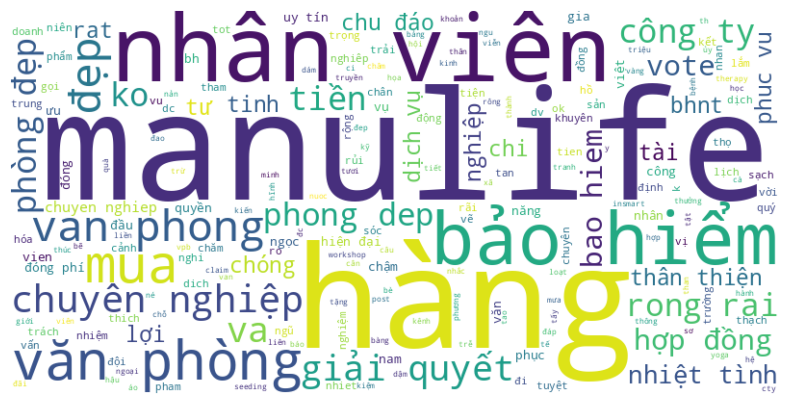

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Áp dụng tiền xử lý cho cột 'Content'
data['processed_content'] = data['Content'].apply(preprocess_text)

# Kết hợp tất cả các nội dung đã xử lý thành một chuỗi
all_text = ' '.join(data['processed_content'])

# Tạo word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None, stopwords=vietnamese_stopwords).generate(all_text)

# Hiển thị word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


[('nhân', 16), ('văn', 16), ('manulife', 15), ('viên', 14), ('phòng', 14), ('đẹp', 14), ('bảo', 13), ('hiểm', 13), ('hàng', 13), ('mua', 12)]


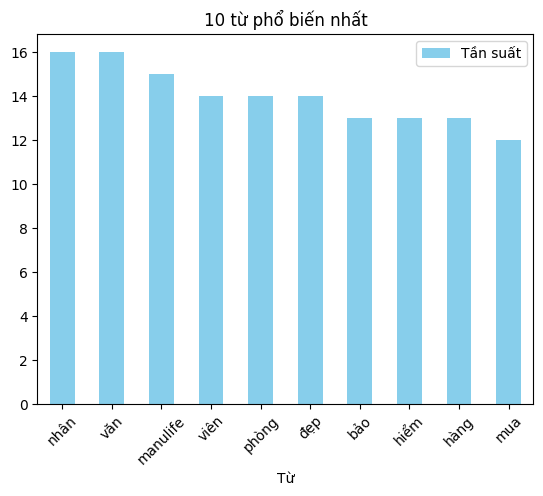

In [ ]:
from collections import Counter

# Gộp tất cả các từ lại sau khi xử lý dữ liệu
all_words = ' '.join(data['processed_content']).split()

# Đếm tần suất xuất hiện của từng từ
word_counts = Counter(all_words)

# Lấy 10 từ phổ biến nhất
common_words = word_counts.most_common(10)
print(common_words)

# Vẽ biểu đồ từ phổ biến
pd.DataFrame(common_words, columns=['Từ', 'Tần suất']).plot(kind='bar', x='Từ', y='Tần suất', color='skyblue', title='10 từ phổ biến nhất')
plt.xticks(rotation=45)
plt.show()


Cặp từ: 'nhân viên' xuất hiện 13 lần.
Cặp từ: 'bảo hiểm' xuất hiện 13 lần.
Cặp từ: 'văn phòng' xuất hiện 13 lần.
Cặp từ: 'khách hàng' xuất hiện 9 lần.
Cặp từ: 'van phong' xuất hiện 8 lần.
Cặp từ: 'chuyên nghiệp' xuất hiện 8 lần.
Cặp từ: 'giải quyết' xuất hiện 7 lần.
Cặp từ: 'làm việc' xuất hiện 7 lần.
Cặp từ: 'công ty' xuất hiện 6 lần.
Cặp từ: 'phòng đẹp' xuất hiện 6 lần.


<Figure size 1000x600 with 0 Axes>

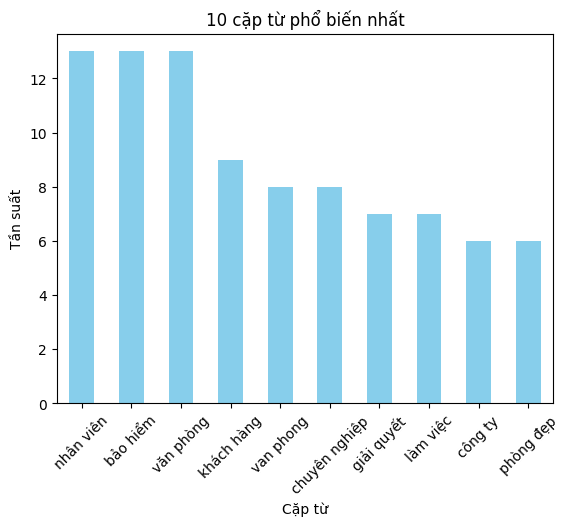

In [ ]:
# Tạo bigrams từ tất cả các từ đã xử lý
all_words = ' '.join(data['processed_content']).split()
bigrams = list(ngrams(all_words, 2))

# Đếm tần suất các bigrams
bigram_counts = Counter(bigrams)

# Lấy 10 cặp từ (bigrams) phổ biến nhất
common_bigrams = bigram_counts.most_common(10)

# Tạo DataFrame cho các cặp từ và tần suất của chúng
bigram_df = pd.DataFrame(common_bigrams, columns=['Cặp từ', 'Tần suất'])
bigram_df['Cặp từ'] = bigram_df['Cặp từ'].apply(lambda x: ' '.join(x))  # Chuyển tuple thành chuỗi

# In số lượng xuất hiện của các cặp từ
for index, row in bigram_df.iterrows():
    print(f"Cặp từ: '{row['Cặp từ']}' xuất hiện {row['Tần suất']} lần.")

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
bigram_df.plot(kind='bar', x='Cặp từ', y='Tần suất', color='skyblue', legend=False, title='10 cặp từ phổ biến nhất')
plt.xlabel('Cặp từ')
plt.ylabel('Tần suất')
plt.xticks(rotation=45)
plt.show()


In [ ]:
data.head(5)

,Reviewer,Content,Date,Stars,Local Guide,Likes,tokens,decoded,processed_content,bigrams
0,Cẩm Thuy,hợp đồng chăm sóc nhân viên hỏi đáp sản phẩm c...,2 tuần trước,1 sao,2 bài đánh giá · 3 ảnh,0,"[0, 2288, 80, 5115, 14005, 1362, 1430, 447, 25...",<s> hợp đồng chăm sóc nhân viên hỏi đáp sản ph...,hợp đồng chăm sóc nhân viên hỏi đáp sản phẩm c...,"[(hợp, đồng), (đồng, chăm), (chăm, sóc), (sóc,..."
1,Tung Anh Yogi,người thân thiện ci yoga therapy workshop,3 tuần trước,5 sao,2 bài đánh giá · 2 ảnh,0,"[0, 18, 1182, 5320, 19245, 9439, 10813, 3417, ...",<s> người thân thiện ci yoga therapy workshop ...,thân thiện ci yoga therapy workshop,"[(thân, thiện), (thiện, ci), (ci, yoga), (yoga..."
2,Hiền Trần,bạn bè người thân mua bảo hiểm lợi mua manulif...,2 tháng trước,1 sao,Local Guide · 25 bài đánh giá · 28 ảnh,0,"[0, 88, 6423, 18, 1182, 188, 1218, 6923, 1596,...",<s> bạn bè người thân mua bảo hiểm lợi mua man...,bạn bè người thân mua bảo hiểm lợi mua manulif...,"[(bạn, bè), (bè, người), (người, thân), (thân,..."
3,Tuấn Anh Nguyễn,manulife ủy quyền công ty giải quyết claim bh ...,4 tháng trước,1 sao,16 bài đánh giá · 17 ảnh,2,"[0, 56401, 21022, 21356, 1231, 493, 675, 6892,...",<s> manulife ủy quyền công ty giải quyết claim...,manulife ủy quyền công ty giải quyết claim bh ...,"[(manulife, ủy), (ủy, quyền), (quyền, công), (..."
4,Quyen Dinh,nhân viên giải quyết quyền lợi tấy cà kênh chậ...,2 tháng trước,1 sao,1 bài đánh giá · 8 ảnh,2,"[0, 1362, 1430, 248, 4436, 493, 1596, 17499, 1...",<s> nhân viên giải quyết quyền lợi tấy cà kênh...,nhân viên giải quyết quyền lợi tấy cà kênh chậ...,"[(nhân, viên), (viên, giải), (giải, quyết), (q..."


Stars
5 sao    123
4 sao     19
1 sao     10
3 sao      6
2 sao      4
Name: count, dtype: int64


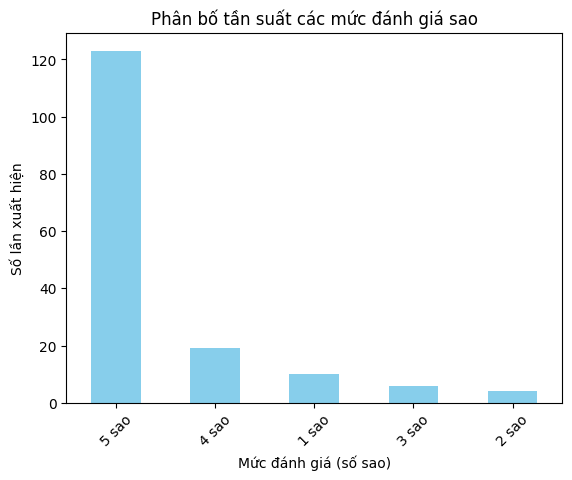

In [ ]:
# Đếm số lần mỗi loại sao (1 sao, 2 sao,...) xuất hiện
star_counts = data['Stars'].value_counts()
print(star_counts)

# Vẽ biểu đồ tần suất số sao
star_counts.plot(kind='bar', color='skyblue', title='Phân bố tần suất các mức đánh giá sao')
plt.xlabel('Mức đánh giá (số sao)')
plt.ylabel('Số lần xuất hiện')
plt.xticks(rotation=45)
plt.show()

Số sao trung bình theo năm:
Năm 2017.0: 5.00 sao
Năm 2018.0: 4.48 sao
Năm 2019.0: 4.64 sao
Năm 2020.0: 4.80 sao
Năm 2021.0: 4.79 sao
Năm 2022.0: 4.88 sao
Năm 2023.0: 3.12 sao
Năm 2024.0: 3.00 sao


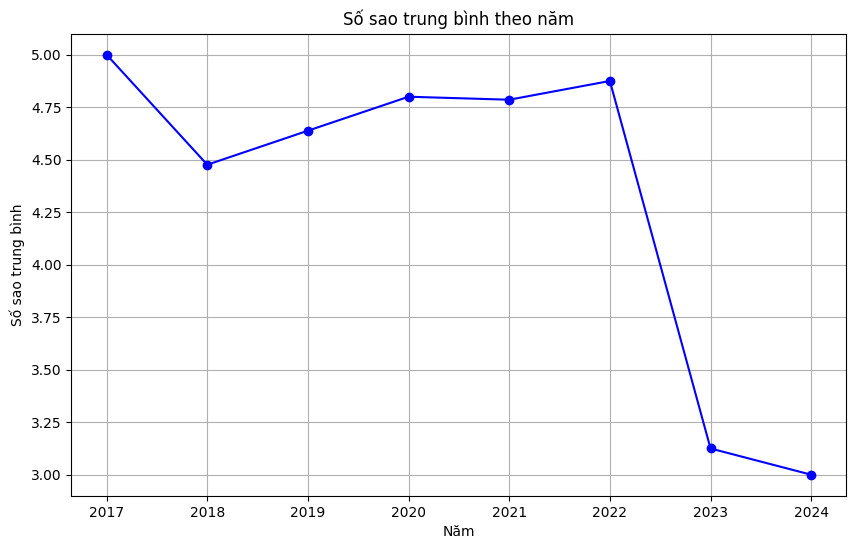

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta

# Bước 1: Chuyển đổi cột 'Stars' thành kiểu số
data['Stars_numeric'] = data['Stars'].apply(lambda x: int(x.split()[0]))  # Chỉ lấy số sao

# Bước 2: Chuẩn hóa chuỗi thời gian
data['Date'] = data['Date'].str.replace("một năm trước", "1 năm")  # Thay đổi "một năm trước" thành "1 năm"

# Bước 3: Chuyển đổi chuỗi thời gian thành kiểu datetime
def convert_to_date(date_str):
    if 'tuần' in date_str:
        weeks_ago = int(re.search(r'\d+', date_str).group()) if re.search(r'\d+', date_str) else 0
        return datetime.now() - timedelta(weeks=weeks_ago)  # Tính ngày từ tuần
    elif 'tháng' in date_str:
        months_ago = int(re.search(r'\d+', date_str).group()) if re.search(r'\d+', date_str) else 0
        return datetime.now() - pd.DateOffset(months=months_ago)  # Tính ngày từ tháng
    elif 'năm' in date_str:
        years_ago = int(re.search(r'\d+', date_str).group()) if re.search(r'\d+', date_str) else 0
        return datetime.now() - pd.DateOffset(years=years_ago)  # Tính ngày từ năm
    return pd.NaT  # Trả về NaT nếu không xác định được

data['Date_converted'] = data['Date'].apply(convert_to_date)  # Áp dụng hàm chuyển đổi cho cột Date

# Bước 4: Trích xuất năm và tính số sao trung bình theo năm
data['Year'] = data['Date_converted'].dt.year  # Lấy năm từ cột Date_converted
average_stars_per_year = data.groupby('Year')['Stars_numeric'].mean().reset_index()  # Tính số sao trung bình theo năm

# Bước 5: In số sao trung bình cho mỗi năm
print("Số sao trung bình theo năm:")
for index, row in average_stars_per_year.iterrows():
    print(f"Năm {row['Year']}: {row['Stars_numeric']:.2f} sao")  # Định dạng số sao trung bình với 2 chữ số thập phân

# Bước 6: Vẽ biểu đồ
plt.figure(figsize=(10, 6))  # Kích thước của biểu đồ
plt.plot(average_stars_per_year['Year'], average_stars_per_year['Stars_numeric'], marker='o', color='blue')  # Vẽ đường biểu diễn
plt.title('Số sao trung bình theo năm')  # Tiêu đề biểu đồ
plt.xlabel('Năm')  # Nhãn trục x
plt.ylabel('Số sao trung bình')  # Nhãn trục y
plt.xticks(average_stars_per_year['Year'])  # Hiển thị các năm trên trục x
plt.grid()  # Bật lưới cho biểu đồ
plt.show()  # Hiển thị biểu đồ


Model

In [ ]:
data['Content'].value_counts()

,count
Content,
,84
hợp đồng chăm sóc nhân viên hỏi đáp sản phẩm cty trách nhiệm k ưu đãi thưởng quà tặng ngoại trừ áo mưa k liên hệ đc nhân viên manulife,1
dich vu tot phuc vu chuyen nghiep,1
trung tâm sạch sẽ hiện đại,1
làm việc lý tưởng,1
công ty tài chính chuyên nghiêp,1
làm việc,1
nhiệt tình giải quyết,1
văn phòng đẹp giảng viên,1


In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Tải mô hình và tokenizer BERT đã được fine-tune cho phân tích cảm xúc
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Hàm để chuyển đổi dữ liệu thành tensor
def encode_data(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=512)

# Dự đoán cho những dòng có Content không phải là N/A
valid_content = data[data['Content'] != '']
if not valid_content.empty:
    inputs = encode_data(valid_content['Content'])

    # Dự đoán cảm xúc
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Chuyển đổi logits thành nhãn
    predicted_classes = torch.argmax(logits, dim=1)

    # Thêm kết quả dự đoán vào DataFrame cho Content không phải N/A
    data.loc[data['Content'] != '', 'Predicted_Sentiment'] = predicted_classes.numpy()

# Phân loại dựa trên số sao cho những dòng có Content là N/A
def classify_sentiment(star_rating):
    if '5 sao' in star_rating:
        return 4  # very positive
    elif '4 sao' in star_rating:
        return 2  # neutral
    elif '3 sao' in star_rating:
        return 1  # negative
    elif '1 sao' in star_rating or '2 sao' in star_rating:
        return 0  # very negative
    return None

# Áp dụng phân loại cho các dòng có Content là N/A
data.loc[data['Content'] == '', 'Predicted_Sentiment'] = data['Stars'].apply(classify_sentiment)

# Chuyển đổi nhãn thành tên cảm xúc (nếu cần)
sentiment_labels = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
data['Sentiment_Label'] = data['Predicted_Sentiment'].apply(lambda x: sentiment_labels[int(x)] if pd.notnull(x) and x < len(sentiment_labels) else 'unknown')

# Hiển thị kết quả
pd.set_option('display.max_rows', None)  # Hiển thị tất cả các hàng
pd.set_option('display.max_columns', None)  # Hiển thị tất cả các cột
pd.set_option('display.expand_frame_repr', False)  # Không ngắt dòng trong DataFrame

print(data[['Reviewer', 'Content', 'Predicted_Sentiment', 'Sentiment_Label']])


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

                                              Reviewer                                            Content  Predicted_Sentiment Sentiment_Label
0                                        Tung Anh Yogi          người thân thiện ci yoga therapy workshop                  4.0   very positive
1                                             Cẩm Thuy  hợp đồng chăm sóc nhân viên hỏi đáp sản phẩm c...                  2.0         neutral
2                                            Hiền Trần  bạn bè người thân mua bảo hiểm lợi mua manulif...                  0.0   very negative
3                                      Tuấn Anh Nguyễn  manulife ủy quyền công ty giải quyết claim bh ...                  0.0   very negative
4                                           Quyen Dinh  nhân viên giải quyết quyền lợi tấy cà kênh chậ...                  0.0   very negative
5                                          Clever Kids  manulife công ty bảo hiểm nuoc việt nam đội ng...                  4.0   very positive

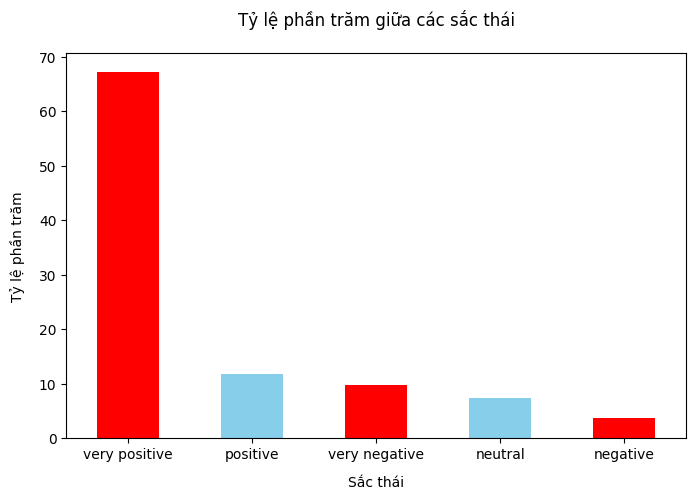

                 count       mean        std  min  25%  50%    75%   max
Sentiment_Label                                                         
negative           6.0   1.666667   4.082483  0.0  0.0  0.0   0.00  10.0
neutral           12.0   4.750000   9.507174  0.0  0.0  0.0   3.00  30.0
positive          19.0   6.263158   4.664787  2.0  2.5  5.0   8.50  20.0
very negative     16.0  16.125000  26.479867  0.0  0.0  7.0  15.25  84.0
very positive    109.0   3.522936   5.698597  0.0  0.0  0.0   6.00  30.0


In [ ]:
# Bước 1: Tính toán tỷ lệ phần trăm giữa các đánh giá Negative và Positive
sentiment_counts = data['Sentiment_Label'].value_counts()
total_counts = sentiment_counts.sum()
percentage_sentiment = (sentiment_counts / total_counts) * 100

# Bước 2: Vẽ biểu đồ tỷ lệ phần trăm
plt.figure(figsize=(8, 5))
percentage_sentiment.plot(kind='bar', color=['red', 'skyblue'])
plt.title('Tỷ lệ phần trăm giữa các sắc thái', pad=20)  # Bỏ gạch ngang
plt.xlabel('Sắc thái', labelpad=10)  # Bỏ gạch ngang
plt.ylabel('Tỷ lệ phần trăm', labelpad=10)  # Bỏ gạch ngang
plt.xticks(rotation=0)  # Giữ cho nhãn trên trục x thẳng
plt.grid(False)  # Tắt lưới ngang
plt.show()

# Bước 3: Nhóm dữ liệu theo nhãn cảm xúc và tính độ dài câu
data['Sentence_Length'] = data['Content'].str.split().str.len()  # Tính độ dài câu
length_analysis = data.groupby('Sentiment_Label')['Sentence_Length'].describe()

# Hiển thị phân tích độ dài câu
print(length_analysis)
